### Research Question 2: What is the causal relationship between enforced seat belt regulations and fatilities per miles driven?

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Avoid False positive chain warnings
pd.options.mode.chained_assignment = None  # default='warn'

In [39]:
#### NHTSA DATA ####
# Read in 2014 the NHTSA dataset for persons involved in accidents
# in which there was at least 1 fatality.
persons_2014 = pd.read_csv("FARS2014NationalCSV/PERSON.CSV", encoding = 'latin-1')

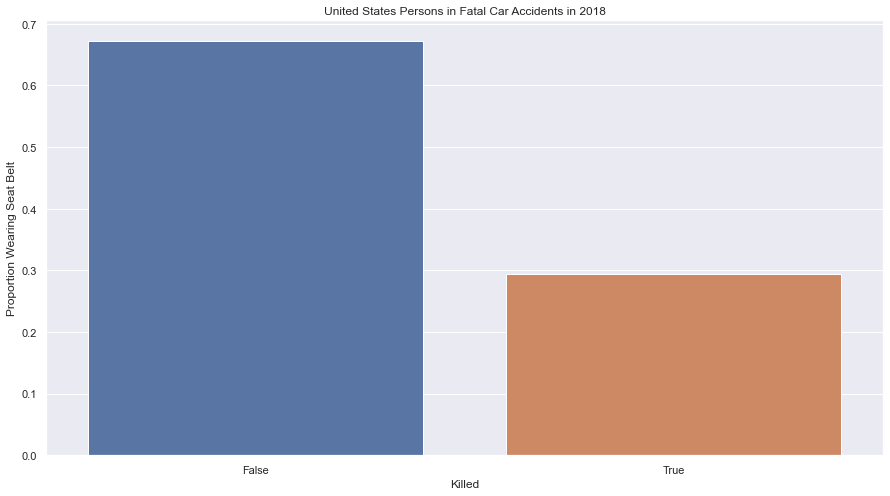

In [40]:
# Plot proportion of people who wore seat belts died in fatal car accidents 
persons_2014["Killed"] = persons_2014["INJ_SEV"] == 4
persons_2014["Belt"] = persons_2014["REST_USE"] == 3
grouped_persons_2014 = persons_2014.groupby("Killed").agg("mean").reset_index()
sns.set(rc = {'figure.figsize':(15,8)})
p = sns.barplot(x="Killed", y = "Belt", data = grouped_persons_2014)
p.set(xlabel = "Killed", ylabel="Proportion Wearing Seat Belt", title="United States Persons in Fatal Car Accidents in 2018");

In [41]:
#### BTS DATA ####
# Read in state transportation data
state_transport_data = pd.read_csv("state_transport_data.csv", encoding = "utf-16", sep='\t')
# dictionary with year that each state adopted the primary seatbelt enforcement law.
# float('inf') if not currently adopted.
# Note that seatbelt laws were sometimes adopted within a specific year (TODO account for this)
# https://www.cdc.gov/motorvehiclesafety/calculator/factsheet/seatbelt.html
year_adopted = {'Alabama': 1991, 'Alaska': 1990, 'Arizona': 1991, 'Arkansas': 2009, 'California': 1986,
       'Colorado': float('inf'), 'Connecticut': 1986, 'Delaware': 1997, 'District of Columbia': 2003,
       'Florida': 2009, 'Georgia': 1988, 'Hawaii': 1985, 'Idaho': float('inf'), 'Illinois': 2003, 'Indiana': 1998,
       'Iowa': 1986, 'Kansas': 2010, 'Kentucky': 2006, 'Louisiana': 1995, 'Maine': 2007, 'Maryland': 1997,
       'Massachusetts': float('inf'), 'Michigan': 2000, 'Minnesota': 2009, 'Mississippi': 2006,
       'Missouri': float('inf'), 'Montana': float('inf'), 'Nebraska': float('inf'), 'Nevada':float('inf'), 'New Hampshire':float('inf'),
       'New Jersey':2000, 'New Mexico':1986, 'New York':1984, 'North Carolina':2006,
       'North Dakota':float('inf'), 'Ohio':float('inf'), 'Oklahoma':1997, 'Oregon':1990, 'Pennsylvania':float('inf'),
       'Rhode Island':2011, 'South Carolina':2005, 'South Dakota':float('inf'), 'Tennessee':2004,
       'Texas': 1985, 'Utah':float('inf'), 'Vermont':float('inf'), 'Virginia':float('inf'),
       'Washington':2002, 'West Virginia':2013, 'Wisconsin':2009, 'Wyoming':float('inf')}

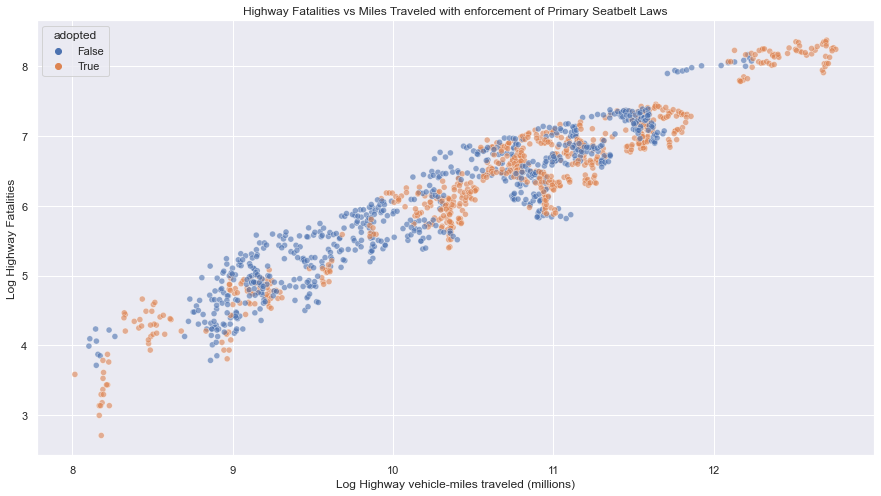

In [42]:
df = pd.pivot_table(state_transport_data, index = ["State", "Year"], columns = "Measures", values="Values").reset_index()
# Puerto Rico removed because it does not include fatalities data
# United states removed because it captures the rest of the data
df_cleaned = df[(df["State"] != "Puerto Rico")&(df["State"] != "United States")&(df["Year"]<=2020)]
df_cleaned["year_adopted"] = df_cleaned["State"].apply(lambda x: year_adopted[x])
df_cleaned["adopted"] = df_cleaned["Year"] >= df_cleaned["year_adopted"]
df_cleaned["Log Highway vehicle-miles traveled (millions)"] = np.log(df_cleaned["Highway vehicle-miles traveled (millions)"])
df_cleaned["Log Highway Fatalities"] = np.log(df_cleaned["Highway Fatalities"])
p = sns.scatterplot(data = df_cleaned, x = "Log Highway vehicle-miles traveled (millions)", y = "Log Highway Fatalities", hue="adopted", alpha = 0.6)
p.set(title="Highway Fatalities vs Miles Traveled with enforcement of Primary Seatbelt Laws");

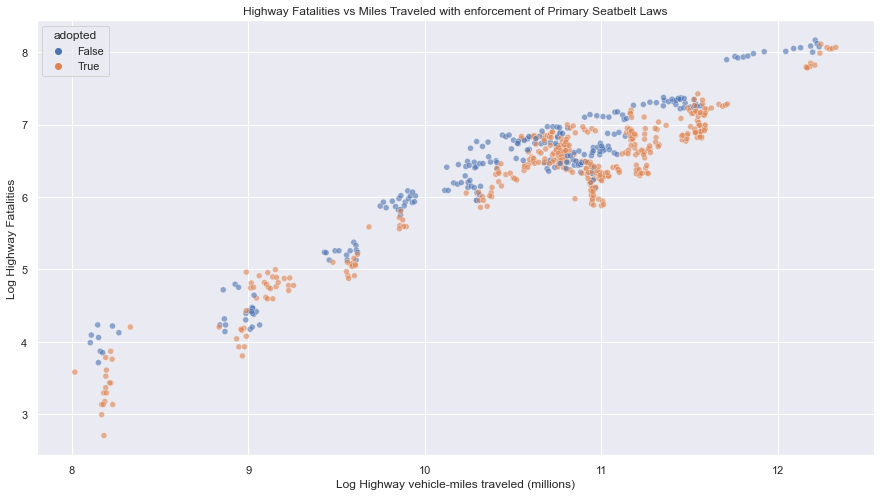

In [43]:
# Highway miles data only goes as far back as 1994
# Reduce set of states to those that had a transition during the given time period.
df_years = df_cleaned[(df_cleaned["year_adopted"] >= 1994)&(df_cleaned["year_adopted"]<float('inf'))]
p = sns.scatterplot(data = df_years, x = "Log Highway vehicle-miles traveled (millions)", y = "Log Highway Fatalities", hue="adopted", alpha = 0.6)
p.set(title="Highway Fatalities vs Miles Traveled with enforcement of Primary Seatbelt Laws");

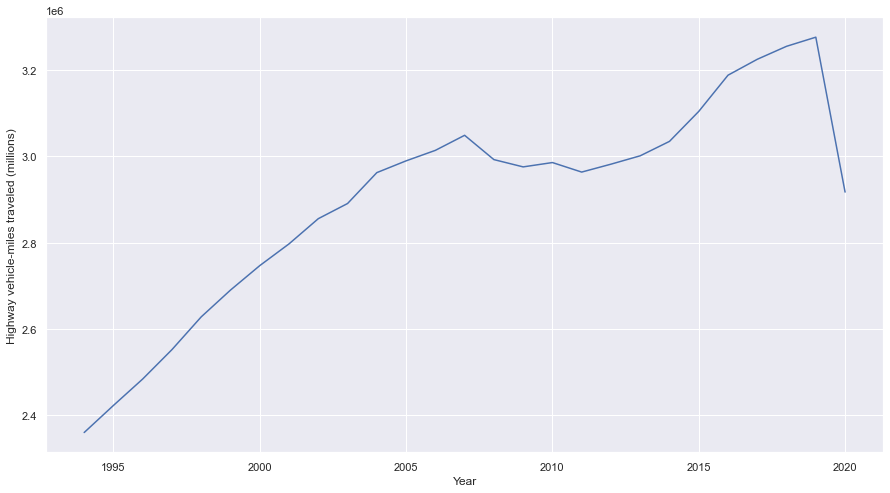

In [44]:
# Visualize how highway miles traveled has changed over time
sns.lineplot(data = df[df["State"] == "United States"], x ="Year", y="Highway vehicle-miles traveled (millions)");

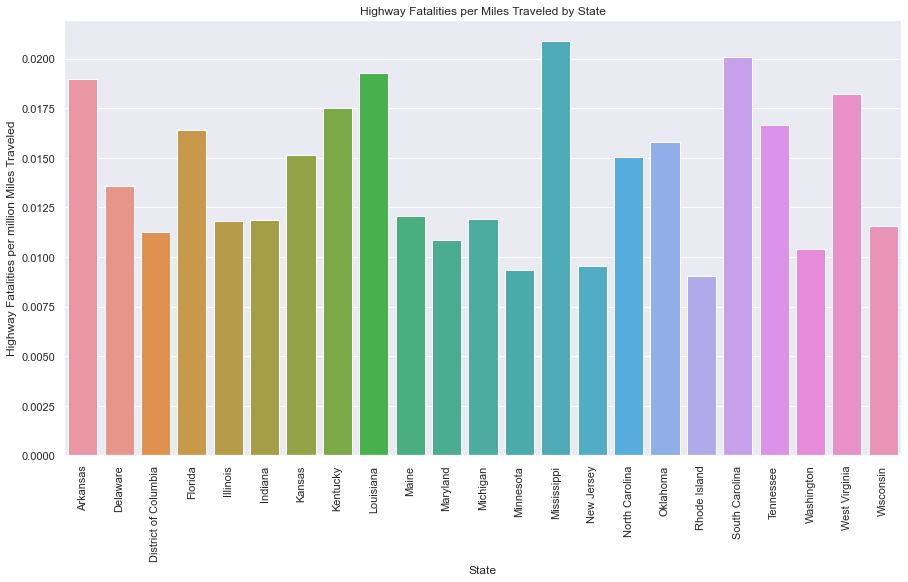

In [45]:
df_ratio = df_years.copy()
df_ratio["Fatals/miles"] = df_years["Highway Fatalities"]/df_years["Highway vehicle-miles traveled (millions)"]
df_ratio = df_ratio.loc[:,["State", "Fatals/miles"]].groupby("State").agg("mean").reset_index()
p = sns.barplot(data = df_ratio, x = "State", y = "Fatals/miles")
p.set_xticklabels(p.get_xticklabels(),rotation = 90)
p.set(title="Highway Fatalities per Miles Traveled by State", ylabel = "Highway Fatalities per million Miles Traveled");

**Describe any trends you observe, and any relationships you may want to follow up on.**
1. Looking at NHTSA data we noticed that the proportion of people in fatal car accidents who died because of the accident was higher for those not wearing seat belts during the accident than for those who were wearing seatbelts during the accident. The first plot shows an example of this relationship for data in 2018. We know that there is a relationship between wearing seat belts and being killed in an accident. We also know that seat belt usage data is not that well collected. Different collection methods are used between states and data is missing from some states in certain years. Also, police may overreport usage to boost states’ ability to receive federal aid. (Alma Cohen and Liran Einav, “The Effects of Mandatory Seat Belt Laws On Driving Behavior and Traffic Fatalities,” November 2001, http://www.law.harvard.edu/programs/olin_center/papers/pdf/341.pdf). We wanted to determine if seat belt laws have a causal effect on fatalities from accidents.
2. The second and third visualizations show the relationship between highway fatalities and millions of miles traveled. There appears to be a linear relationship between the two. We plotted the data on a  log-log scale to expand the lower part of the scatter plot so that differences between data points in this range were more clear. Each point represents the values associated with a state in a particular year. Looking at the first plot it is not clear that there is much of a difference between points that occurred after states had adopted primary seat belt enforcement laws and those that hadn’t. We noticed, however, that data for highway miles traveled was only present from the year 1994 onwards. (A closer look into this revealed that collection methods for highway miles traveled changed and making comparisons across these datasets is not valid). This meant we had data for some states that did not include a transition from no enforcement to enforcement. Removing states whose transition did not occur during the time period revealed an apparent relationship between primary enforcement of seat belt regulations and fatalities per million miles traveled. The second plot shows this relationship.
3. The fourth visualization simply shows highway miles driven over time in the U.S. Of particular interest from this plot is the significant drop in the graph that occurred in 2020. We suspect this is due to COVID and we may remove data from 2020 to account for this difference.
4. The fifth visualization shows the average rate of fatalities per million miles traveled for the states that transitioned to primary enforcement in the available year range. This shows that regional differences are relevant.


**Describe any data cleaning steps you took. How will these decisions impact your models and inferences?**
- We removed rows with the state value of ‘Puerto Rico’ as fatality data was missing for all of these rows. This should not affect model too much as we are just removing one region that is not related to other regions
- For certain analyses we removed states with the value of ‘United States’ as we wanted to get data from each state and these rows had values associated with the entire U.S. (aggregated). This does not affect modeling or inference.
- We decided to include data only for states whose transition occurred between 1994 and 2020 (which is when highway miles traveled data is present in the dataset). This will likely impact the model because we are excluding data points with a very specific selection bias (against states who transitioned early and states who have not yet transitioned). The causal inferences we make may only be valid for the states that are included in the model.
- When indicating the year associated with a states’ transition to seatbelt laws, we included the year during which seat belt laws were introduced as years in which the laws were present. This is potentially problematic because a state in which seat belt law was introduced on December 30 2020 — for example — would be categorized as having seat belt laws in the year 2020 when in reality it did not. Because our data is only available at a yearly granularity we must make a decision in this direction or the other. This means some data points on the transition years may be categorized as having seat belt laws when they would be better categorized as not having seat belt laws. These points may influence the validity of our analysis.
- Excluding data from 2020 will avoid the need to account for the changes brought about by COVID — so this will likely simplify the model. It will mean that any causal relationships inferred may not apply when COVID is a factor.
- Another important data decision not necessarily related to cleaning is the notion that fatalities per million miles traveled is a worthwhile measure of driver safety.


**Explain how your visualizations should be relevant to your research questions: either by motivating the question, or suggesting a potential answer. You must explain why they are relevant.**
1. The first visualization (and the idea that good seat belt usage data is not readily available) motivates the question about the causal effect of seat belt safety laws on fatalities. Instead of trying to establish causality between seat belt wearing and fatalities or between seat belt laws and seat belt usage, we try to establish causality between seat belt laws and fatalities.
2. The second and third visualizations show that there is some relationship between seatbelt safety law adoption and fatalities, especially when looking at data for states who transitioned from not having seat belt laws in the relevant range. This is relevant because it shows an association between our treatment and outcome that suggests a causal relationship is possible.
3. The fourth visualization shows that yearly differences in miles traveled may be a relevant component of the modeling process. In particular, it suggests that COVID created some significant differences and led to our exclusion of data from 2020 and onwards.
4. The fifth visualization indicates that there are differences between states when it comes to fatalities per million miles traveled. This suggests that any answer to our research question will need to account for region.


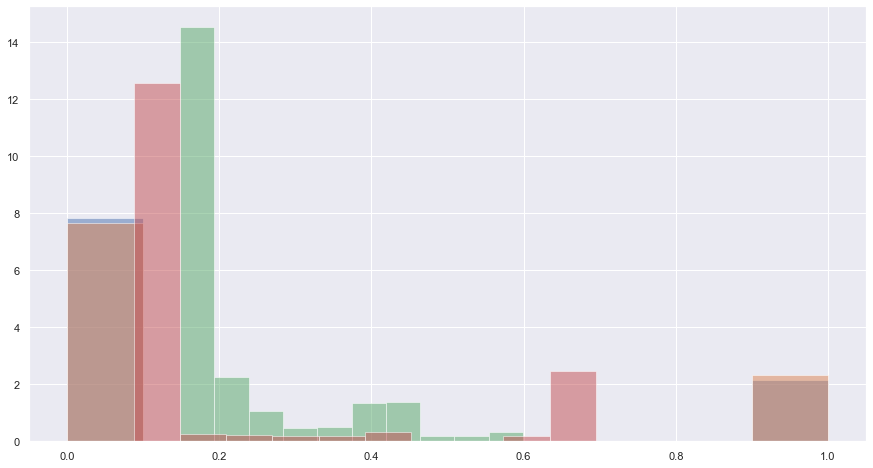

In [51]:
### CALCULATE PROPENSITY SCORES ###

# one hot encoding for states
from sklearn.preprocessing import OneHotEncoder
def ohe_column(data, name):
    """
    One-hot-encodes elements in the column named NAME. New columns are of the form NAME_ENTRY.
    """
    enc = OneHotEncoder(sparse=False)
    enc.fit(data[[name]])
    df = pd.DataFrame(enc.transform(data[[name]]), columns = enc.get_feature_names_out(), index = data.index)
    return data.join(df)

temp = df_cleaned.copy() ###### TODO make sure this is the correct df.
temp["Fatals/miles"] = temp["Highway Fatalities"]/temp["Highway vehicle-miles traveled (millions)"]
temp2 = temp.copy()
temp2 = temp2[(temp2["year_adopted"] >= 1994)&(temp2["year_adopted"]<float('inf'))]
temp = ohe_column(temp, "State")
df_ohe = ohe_column(temp, "Year")
temp2 = ohe_column(temp2, "State")
df_ohe2 = ohe_column(temp2, "Year")
# df_ohe = ohe_column(temp, "State")
# create logistic regression model
confounders = ["State_"+name for name in df_ohe["State"].unique()] \
+ ["Year_"+str(int(year)) for year in df_ohe["Year"].unique()]
# df_ohe["Year"] = (df_ohe["Year"]-1994)/26
confounders2 = ["State_"+name for name in df_ohe2["State"].unique()] \
+ ["Year_"+str(int(year)) for year in df_ohe2["Year"].unique()]
treatment = "adopted"
outcome = "Fatals/miles"
X = df_ohe.loc[:, confounders]
Z = df_ohe.loc[:, treatment]
Y = df_ohe.loc[:, outcome]
X2 = df_ohe2.loc[:, confounders2]
Z2 = df_ohe2.loc[:, treatment]
Y2 = df_ohe2.loc[:, outcome]

from sklearn.linear_model import LogisticRegression as LR
lr = LR(penalty='none', max_iter=200, random_state=0)
lr.fit(X, Z)
lr2 = LR(penalty='none', max_iter=200, random_state=0)
lr2.fit(X2, Z2)

# generate propensity score using specified model
def generate_propensity_score(model, X, Y, Z):
    e = model.predict_proba(X)[:, 1]
    return e

prop_scores = generate_propensity_score(lr, X, Y, Z)
prop_scores2 = generate_propensity_score(lr2, X2, Y2, Z2)
plt.hist(prop_scores, density=True, label="lr no trim", alpha=0.5)
plt.hist(prop_scores2, density=True, label="lr trim", alpha=0.5)

# use Boosted model to generate propensity scores
from sklearn.ensemble import GradientBoostingClassifier as GBC
gbc = GBC(learning_rate = 0.05, random_state=12) # TODO can you improve upon this model?
gbc.fit(X, Z)
gbc2 = GBC(learning_rate = 0.05, random_state=12) # TODO can you improve upon this model?
gbc2.fit(X2, Z2)

gbc_prop_scores = generate_propensity_score(gbc, X, Y, Z)
gbc_prop_scores2 = generate_propensity_score(gbc2, X2, Y2, Z2)
plt.hist(gbc_prop_scores, density=True, label="gbc no trim", alpha=0.5)
plt.hist(gbc_prop_scores2, density=True, label="gbc trim", alpha=0.5);

In [52]:
### IPW ###
def ipw_estimate(data, treatment, outcome, prop_scores, left=0, right=1):
    temp_df = data.copy()
    n = len(temp_df)
    temp_df["e"] = prop_scores
    temp_df = temp_df[(temp_df["e"] > left) & (temp_df["e"] < right)]
    temp_df["ipw"] = temp_df[outcome]/(temp_df["e"]**temp_df[treatment]*(1-temp_df["e"])**(1-temp_df[treatment]))
    grouped = temp_df.loc[:,[treatment, "ipw"]].groupby(treatment).agg("sum")
    return (grouped.loc[1, "ipw"] - grouped.loc[0, "ipw"])/n

gbc_estimate = ipw_estimate(df_ohe, treatment, outcome, gbc_prop_scores, left=0.1, right=0.9)
lr_estimate = ipw_estimate(df_ohe, treatment, outcome, prop_scores, left=0, right=1)
gbc_estimate2 = ipw_estimate(df_ohe2, treatment, outcome, gbc_prop_scores2, left=0.1, right=0.9)
lr_estimate2 = ipw_estimate(df_ohe2, treatment, outcome, prop_scores2, left=0, right=1)
print("Interpret as: The treatment has <estimate> effect on fatalities per million miles travelled.")
print("GBC Estimate:", gbc_estimate)
print("LR Estimate:", lr_estimate)
print("GBC Estimate Trimmed:", gbc_estimate2)
print("LR Estimate Trimmed:", lr_estimate2)

Interpret as: The treatment has <estimate> effect on fatalities per million miles travelled.
GBC Estimate: 0.005214945258965265
LR Estimate: -0.0025277724851692444
GBC Estimate Trimmed: 0.00544488368124367
LR Estimate Trimmed: -0.0019845778582570656
